<a href="https://colab.research.google.com/github/dcordovao/neural_nerworks/blob/master/Enunciado_T2_Pregunta1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Convolucionales y sus aplicaciones </H3>
<H3 align='center'> Camilo Maldonado - Diego Córdova </H3>
<hr style="height:2px;border:none"/>

<div style="text-align: right"> 
  
**Temas**: Diseño y entrenamiento de Redes Neuronales Convolucionales (CNNs), Regularización en Redes Convolucionales, *Transfer Learning* y Aplicaciones de las Redes Neuronales Convolucionales
  
  </div>

<hr style="height:2px;border:none"/>


Secciones:

[1.](#primero) Convolutional Neural Networks (CNN) en CIFAR.  
[2.](#segundo) Transfer Learning.   
[3.](#tercero) Convolutional Neural Network sobre texto.



<a id="primero"></a>
## 1. Convolutional Neural Networks (CNN) en CIFAR10

En esta sección trabajaremos con CNN en un dataset bastante conocido y utilizado por la comunidad para experimentar reconocimiento de objetos en imágenes: CIFAR10 [3]. Son 60.000 imágenes RGB de 32x32 pixeles, que contienen las siguientes clases:

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco



#### Se importan librerías necesarias


In [0]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler, Callback
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers
import numpy as np   
import os   
from keras.datasets import cifar10
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras import regularizers


%matplotlib inline

Using TensorFlow backend.


### Primero definimos nuestros conjuntos de datos
(i) dos matrices  x_train, y_train correspondientes a las imágenes y etiquetas de entrenamiento  
(ii) dos matrices x_test, y_test correspondientes a las imágenes y etiquetas de pruebas  
(iii) dos matrices x_val, y_val correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación

Cada conjunto tiene su fin, (i) para entrenar el modelo y (ii) para determinar la calidad del modelo. Por último tenemos los dato de validación para determinar parámetros en el modelo

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Validation Data
x_val = x_train[:5000]
y_val = y_train[:5000]
# Remove validation data from training data
x_train = x_train[5000:]
y_train = y_train[5000:]

### Corroboramos un poco de la data para darnos una idea bajo el tipo de dato que estamos trabajando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


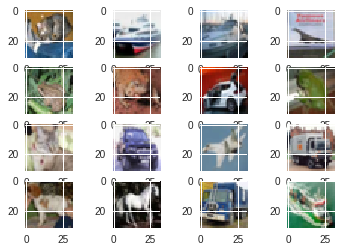

In [0]:
# Show images in group of 4
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
show_imgs(x_test[:16])

### Normalizamos los datos
Normalizamos y transformamos los *target* para trabajarlo bajo clases: La normalización es para poder trabajar de mejor manera independiente de la escala de valor de los datos y las clases para una classificación multiclase.

In [0]:
# Shape (32,32,3)
x_train = x_train/255 
x_test = x_test/255 
x_val = x_val/255

# Creates categories
num_classes = len(label_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

### Definimos una CNN ($C \times P \times C \times P \times F \times F$)


* C: Capa convolucional de 64 mapeos de filtro, con filtro de 3x3. Cada una tiene una funciónd e activación ReLU.
* P: Capa de pooling de tamaño 2x2, con stride 2. 
* F: La capa MLP tendrá 512 en la primera capa de entrada y la de salida con 10 neuronas para cada clase.

In [0]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

### Dimensionalidad a través de la red

La red recibe una imagen RGB de tamaño 32x32x3, donde la primera capa convolucional no modifica la dimensionalidad ya que trabaja con 64 mapeos de tamaño 32x32x3. En la primera capa de  pooling baja a 1 cuarto los tamaños de la imagen con la misma cantidad de mapeos (16x16x3). La dimensión no cambia hasta el siguiente pooling donde es la misma idea, baja a 1 cuarto la dimensionalidad, manteniendo la cantidad de mapeos. Luego se pasa a un arreglo completo de tamaño 1x4096, que entra a la MLP.

### Funciones auxiliares

La primera nos permitirá obtener la evaluación del modelo en los diferentes epochs, es decir su precisión y pérdida dela función de coste. La segunda permite que a través del transcurso de epoch el learning rate vaya bajando para que no tenga problemas al converger, se usa debido a que necesita algunos pasos mayores al inicio y luego ir achicandolos.

In [0]:
# Auxiliar function

# https://github.com/keras-team/keras/issues/2548?fbclid=IwAR0sPb66MnT8TwpkDl3oVfHaDQvWeMRYC_H_Tw30-ycZqGyWxDdU53tppG4#issuecomment-215664770
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
    
        
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

### Entrenamiento CNN simple (Con step decay y SGD)

In [0]:
epochs = 25
batch_size = 128

test_loss = []
test_acc = []


 
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))])

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 11s 247us/step - loss: 2.1742 - acc: 0.2148 - val_loss: 2.0034 - val_acc: 0.2916

Testing loss: 2.011762713432312, acc: 0.2916

Epoch 2/25
45000/45000 [==============================] - 7s 154us/step - loss: 1.9249 - acc: 0.3220 - val_loss: 1.8463 - val_acc: 0.3490

Testing loss: 1.8472266117095948, acc: 0.3483

Epoch 3/25
45000/45000 [==============================] - 7s 155us/step - loss: 1.7994 - acc: 0.3717 - val_loss: 1.7460 - val_acc: 0.3878

Testing loss: 1.742569186782837, acc: 0.3874

Epoch 4/25
45000/45000 [==============================] - 7s 155us/step - loss: 1.6844 - acc: 0.4103 - val_loss: 1.6065 - val_acc: 0.4400

Testing loss: 1.613213780593872, acc: 0.4359

Epoch 5/25
45000/45000 [==============================] - 7s 154us/step - loss: 1.5720 - acc: 0.4494 - val_loss: 1.5265 - val_acc: 0.4682

Testing loss: 1.5262284826278687, acc: 0.4694

Epoch 6/25
45000/45000 

#### Graficamos lo obtenido del modelo 

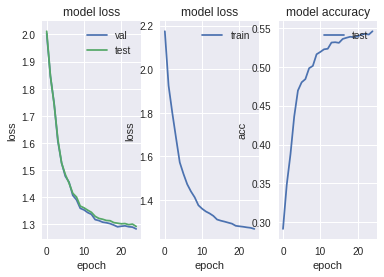

In [0]:
# summary of training and testing history 
plt.subplot(1,3,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

plt.subplot(1,3,3)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper right')
plt.show()



##### Entrenamiento
Se puede observar que no ocurre overfitting y además los datos de test no van muy alejados de los de validación. Además se presenta una buena precisión del testing que  llega hasta 0.5456, es decir casi un 55% de precisión.

### Entrenamiento red simple CNN (con RMSProp y step decay)

In [0]:
batch_size = 128
epochs = 25
test_loss = []
test_acc = []

lrate = LearningRateScheduler(step_decay)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))])

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 8s 175us/step - loss: 0.8298 - acc: 0.7146 - val_loss: 0.9275 - val_acc: 0.6758

Testing loss: 0.9475037983894348, acc: 0.6747

Epoch 2/25
45000/45000 [==============================] - 8s 167us/step - loss: 0.6676 - acc: 0.7703 - val_loss: 1.1107 - val_acc: 0.6486

Testing loss: 1.1097404185295106, acc: 0.6457

Epoch 3/25
45000/45000 [==============================] - 8s 168us/step - loss: 0.5274 - acc: 0.8183 - val_loss: 0.9507 - val_acc: 0.6972

Testing loss: 0.9840279175758362, acc: 0.6925

Epoch 4/25
45000/45000 [==============================] - 8s 167us/step - loss: 0.3992 - acc: 0.8641 - val_loss: 1.0653 - val_acc: 0.6808

Testing loss: 1.0898826288223267, acc: 0.6677

Epoch 5/25
45000/45000 [==============================] - 8s 167us/step - loss: 0.1972 - acc: 0.9383 - val_loss: 1.0778 - val_acc: 0.7202

Testing loss: 1.0860445314407348, acc: 0.7121

Epoch 6/25
45000/4500

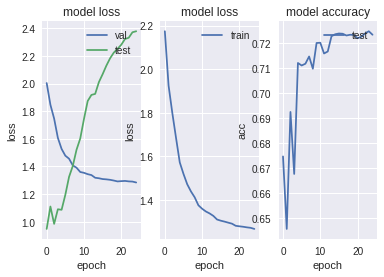

In [0]:
# summary of training and testing history 
plt.subplot(1,3,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

plt.subplot(1,3,3)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper right')
plt.show()


#### Entrenamiento
Se ve claramente un modelo mejor que aunque tenga un mayor valor de pérdida para el de testing, se tiene una buena precisión desde el inicio. Aunque cabe destacar que tiende a ser más errático entre epochs este optimizador.

### Efecto del tamaño de filtro en shallow y deep network

Se evaluarán diferentes tamaños de filtros para dos tipos de redes, para una comparación de sus errores a través de gráficos.

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
 - 11s - loss: 2.0929 - acc: 0.2630 - val_loss: 1.9606 - val_acc: 0.3224

Testing loss: 1.9699932762145995, acc: 0.3202

Epoch 2/15
 - 7s - loss: 1.9154 - acc: 0.3369 - val_loss: 1.8610 - val_acc: 0.3454

Testing loss: 1.8756475276947022, acc: 0.3464

Epoch 3/15
 - 7s - loss: 1.8496 - acc: 0.3586 - val_loss: 1.8071 - val_acc: 0.3718

Testing loss: 1.8178667348861695, acc: 0.3651

Epoch 4/15
 - 7s - loss: 1.7993 - acc: 0.3758 - val_loss: 1.7773 - val_acc: 0.3796

Testing loss: 1.7821947639465332, acc: 0.3779

Epoch 5/15
 - 7s - loss: 1.7621 - acc: 0.3903 - val_loss: 1.7459 - val_acc: 0.3952

Testing loss: 1.7540371961593628, acc: 0.392

Epoch 6/15
 - 7s - loss: 1.7395 - acc: 0.3990 - val_loss: 1.7211 - val_acc: 0.3966

Testing loss: 1.7302427528381348, acc: 0.396

Epoch 7/15
 - 7s - loss: 1.7200 - acc: 0.4038 - val_loss: 1.7168 - val_acc: 0.3964

Testing loss: 1.7190465141296387, acc: 0.3994

Epoch 8/15
 - 7s - loss: 1.7007 - a

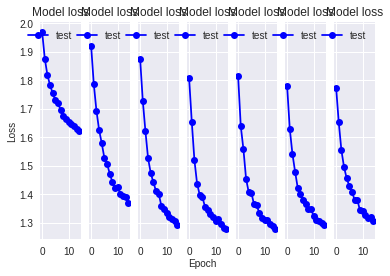

In [0]:
plot = 0
f, axarr = plt.subplots(1,7, sharey=True)
batch_size = 128
f.text(0.5, 0.04, 'Epoch', ha='center', va='center')
f.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
       
for nc in [1,3,5,10,15,20,30]:
  epochs = 15
  test_loss = []
  test_acc = []
  
  # Shallow network
  model = Sequential()
  model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)
  
  # Two subplots, the axes array is 1-d

  axarr[plot].plot(test_loss,'bo-')
  axarr[plot].set_title('Model loss')
  axarr[plot].legend(['test'], loc='upper right')
  plot += 1

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
 - 18s - loss: 1.9176 - acc: 0.3136 - val_loss: 1.6375 - val_acc: 0.4240
Epoch 2/15
 - 16s - loss: 1.5346 - acc: 0.4544 - val_loss: 1.4204 - val_acc: 0.4974
Epoch 3/15
 - 16s - loss: 1.3683 - acc: 0.5138 - val_loss: 1.2830 - val_acc: 0.5442
Epoch 4/15
 - 16s - loss: 1.2615 - acc: 0.5548 - val_loss: 1.2148 - val_acc: 0.5688
Epoch 5/15
 - 16s - loss: 1.1573 - acc: 0.5946 - val_loss: 1.1524 - val_acc: 0.5948
Epoch 6/15
 - 16s - loss: 1.1099 - acc: 0.6115 - val_loss: 1.1167 - val_acc: 0.6094
Epoch 7/15
 - 16s - loss: 1.0648 - acc: 0.6287 - val_loss: 1.1471 - val_acc: 0.5926
Epoch 8/15
 - 16s - loss: 1.0279 - acc: 0.6414 - val_loss: 1.0683 - val_acc: 0.6208
Epoch 9/15
 - 16s - loss: 0.9869 - acc: 0.6566 - val_loss: 1.0835 - val_acc: 0.6192
Epoch 10/15
 - 16s - loss: 0.9274 - acc: 0.6810 - val_loss: 1.0142 - val_acc: 0.6426
Epoch 11/15
 - 16s - loss: 0.9046 - acc: 0.6878 - val_loss: 1.0260 - val_acc: 0.6436
Epoch 12/15
 - 16s - loss

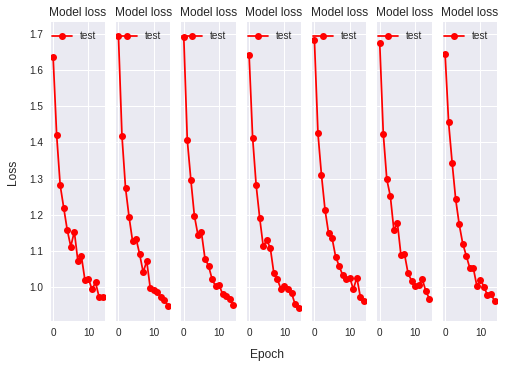

In [0]:
plot = 0
f, axarr = plt.subplots(1,7, sharey=True)
batch_size = 32
f.text(0.5, 0.04, 'Epoch', ha='center', va='center')
f.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical')
       
for nc in [1,3,5,10,15,20,30]:
  epochs = 15
  test_loss = []
  test_acc = []
  
  # deep network
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)
  
  # Two subplots, the axes array is 1-d


  axarr[plot].plot(test_loss,'ro-')
  axarr[plot].set_title('Model loss')
  axarr[plot].legend(['test'], loc='upper right')
  plot += 1

#### Entrenamiento y gráficos
Se puede observar que para la *Shallow network* los valores de filtros que mejor funcionan en pocos epochs son que tienden no ser muy grandes pero a la vez tampoco exageradamente pequeños, en este caso 5x5 y 10x10. Por otor lado para la red más prfunda no tiene gran influencia el tamaño pero muy levemente igual muestra mejores valores para 10x10.

### Comparación 𝐶×𝑃×𝐶×𝑃×𝐹×𝐹  versus  𝐶×𝐶×𝑃×𝐶×𝐶×𝑃×𝐹×𝐹

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_20 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
__________

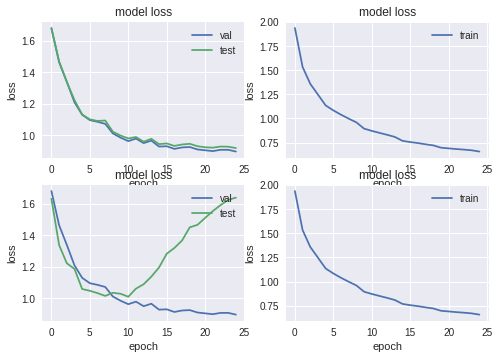

In [0]:
batch_size = 32
epochs = 25

# Model 1
test_loss = []
test_acc = []
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Model 2
modelD = Sequential()
modelD.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (3, 3), padding='same'))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(128, (3, 3), padding='same'))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Flatten())
modelD.add(Dense(512))
modelD.add(Activation('relu'))
modelD.add(Dense(10))
modelD.add(Activation('softmax'))
modelD.summary()

# Training and testing model 1
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# Training and testing model 2
test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
modelD.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
historyD = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,4)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()R

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       401536    
_________________________________________________________________
activation_30 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
__________

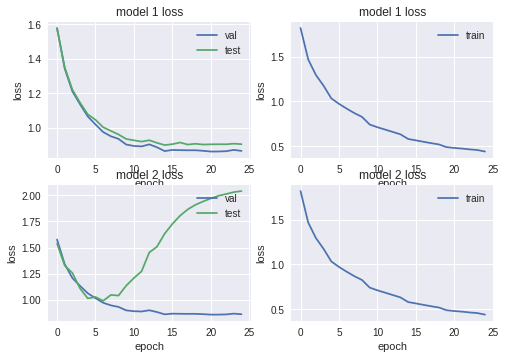

In [0]:
batch_size = 32
epochs = 25

# Model 1
test_loss = []
test_acc = []
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Model 2
modelD = Sequential()
modelD.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (7, 7), padding='same'))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Conv2D(128, (7, 7), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(128, (7, 7), padding='same'))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Flatten())
modelD.add(Dense(512))
modelD.add(Activation('relu'))
modelD.add(Dense(10))
modelD.add(Activation('softmax'))
modelD.summary()

# Training and testing model 1
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# Training and testing model 2
test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
modelD.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
historyD = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,4)
plt.plot(history.history['loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
 - 35s - loss: 2.2095 - acc: 0.2486 - val_loss: 1.6857 - val_acc: 0.4058

Testing loss: 1.6994706624984741, acc: 0.3953

Epoch 2/25
 - 33s - loss: 1.6645 - acc: 0.4170 - val_loss: 1.5303 - val_acc: 0.4904

Testing loss: 1.5412471696853638, acc: 0.4846

Epoch 3/25
 - 33s - loss: 1.4848 - acc: 0.5004 - val_loss: 1.5014 - val_acc: 0.5160

Testing loss: 1.5124947093963623, acc: 0.5056

Epoch 4/25
 - 33s - loss: 1.3582 - acc: 0.5534 - val_loss: 1.2510 - val_acc: 0.5844

Testing loss: 1.261657691192627, acc: 0.5827

Epoch 5/25
 - 33s - loss: 1.1295 - acc: 0.6280 - val_loss: 1.0339 - val_acc: 0.6606

Testing loss: 1.0430527046203613, acc: 0.6587

Epoch 6/25
 - 32s - loss: 1.0774 - acc: 0.6484 - val_loss: 1.0167 - val_acc: 0.6694

Testing loss: 1.0449931650161743, acc: 0.6629

Epoch 7/25
 - 33s - loss: 1.0380 - acc: 0.6646 - val_loss: 1.0879 - val_acc: 0.6514

Testing loss: 1.115525527572632, acc: 0.6409

Epoch 8/25
 - 32s - loss: 1.0

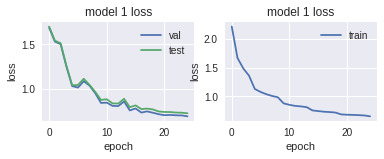

In [0]:
batch_size = 128
epochs = 25

# Model 2
modelD = Sequential()
modelD.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.3))
modelD.add(Conv2D(128, (10, 10), padding='same', input_shape=x_train.shape[1:]))
modelD.add(Activation('relu'))
modelD.add(Conv2D(128, (12, 12), padding='same',kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.5))
modelD.add(Flatten())
modelD.add(Dense(512))
modelD.add(Activation('relu'))
modelD.add(Dense(10))
modelD.add(Activation('softmax'))
#modelD.summary()

test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
modelD.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')


### Entrenamiento
Se pudo observar que al correr ambos modelos, sin regularizadores y dropout el modelo mas profundo produce overfitting muy rápido, pero al agregar los regularizadores y dropout mejora el comportamiento de la red más profundo a través de los epochs. Además se ve de mejor desempeño la red profundo, igual se provó con filtros mayores al inicio y al final, resultando de mejor manera que son más convenientes los filtros más grande en capas más profundas.

> **h)** Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*.  
Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
```python
...
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
...
```

### Stride v/s pooling

En este punto se verá la diferencia entre ocupar una capa de pooling o una convolucional  con stride 2.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_81 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 128)       401536    
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 8192)              0         
__________

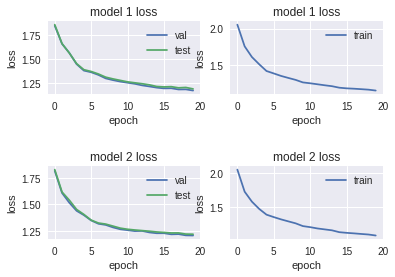

In [0]:
batch_size = 128
epochs = 20

plt.subplots_adjust(hspace = 1)

# Model 1
test_loss = []
test_acc = []
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Model 2
test_loss = []
test_acc = []
modelD = Sequential()
modelD.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
modelD.add(Conv2D(128, (7, 7), padding='same'))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
modelD.add(Flatten())
modelD.add(Dense(512))
modelD.add(Activation('relu'))
modelD.add(Dense(10))
modelD.add(Activation('softmax'))
modelD.summary()

# Training and testing model 1
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# Training and testing model 2
test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
modelD.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
historyD = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,3)
plt.plot(historyD.history['val_loss'])
plt.plot(test_loss)
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,4)
plt.plot(historyD.history['loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

#### Entrenamiento
Se puede ver que no hay casi diferencia entre ambos métodos, siendo equivalentes a priori, pero si se ven los epochs se puede ver que es más rápido usa rpooling, ya que el costo es mucho menor. Al final si ambos métodos son casi equivalentes, conviene usar pooling por la eficiencia de ejecución

### Generación de datos (con rotaciones y medas)

Compararemos uno de los modelos anteriores y su desempeño con los datos normal, con el mismo modelo pero para datos donde se le agregan pequeñas perturbaciones a los datos que se tienen para generar un mayor conglomerado.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_89 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 128)       401536    
_________________________________________________________________
activation_90 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
__________

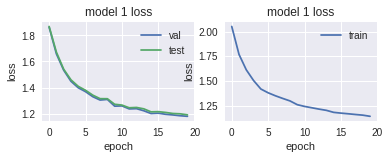

In [0]:
# Model 1
test_loss = []
test_acc = []
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Training and testing model 1
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

Epoch 1/20
351/351 [==============================] - 31s 87ms/step - loss: 1.3382 - acc: 0.5248 - val_loss: 1.2070 - val_acc: 0.5775

Testing loss: 1.2070048675537108, acc: 0.5775

Epoch 2/20
351/351 [==============================] - 30s 87ms/step - loss: 1.2982 - acc: 0.5429 - val_loss: 1.2560 - val_acc: 0.5608

Testing loss: 1.256046616744995, acc: 0.5608

Epoch 3/20
351/351 [==============================] - 29s 84ms/step - loss: 1.2585 - acc: 0.5579 - val_loss: 1.1421 - val_acc: 0.6035

Testing loss: 1.1420508375167846, acc: 0.6035

Epoch 4/20
351/351 [==============================] - 29s 82ms/step - loss: 1.2385 - acc: 0.5614 - val_loss: 1.1725 - val_acc: 0.5788

Testing loss: 1.1725222967147828, acc: 0.5788

Epoch 5/20
351/351 [==============================] - 29s 83ms/step - loss: 1.1941 - acc: 0.5809 - val_loss: 1.0980 - val_acc: 0.6183

Testing loss: 1.0980196048736572, acc: 0.6183

Epoch 6/20
351/351 [==============================] - 28s 81ms/step - loss: 1.1725 - acc: 0

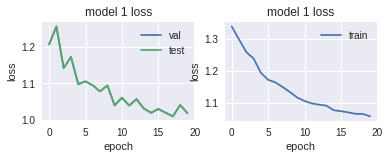

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

test_loss = []
test_acc = []
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]// batch_size, epochs=epochs,validation_data=(x_test, y_test),callbacks=[lrate,TestCallback((x_test, y_test))])

# Plot validation and test data
plt.subplot(2,2,1)
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val','test'], loc='upper right')

# Plot training loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

#### Entrenamiento
Se ve una mejora en la precisión del modelo con datos generados, para los datos de testing. A la vez se ve una mejora a través de los epochs más errática en los gráficos.

> **j)** Para una comparación del desempeño de la red neuronal, pre-procese el dataset de CIFAR-10 y calcule los descriptores manuales SIFT, para un mejor entendimiento de éstos consulte:  https://ianlondon.github.io/blog/how-to-sift-opencv/ y https://docs.opencv.org/3.4.3/da/df5/tutorial_py_sift_intro.html. Como se genera un descriptor de 128 dimensiones para cada *keypoint* comprima esta información de alguna manera, comente sobre la operación.

> Es necesario instalar *OpenCV* para realizar el cálculo de este descriptor.  
```python
!pip install opencv-python==3.1 opencv-contrib-python==3.4.2.16
```
  

>```python
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
cifar_sift = calculate_sift(X)
```
*Recuerde escalar los datos antes de entregárselos al modelo*

> **j.1)** Visualice los *keypoint* para una mejor comprensión visual de lo que son los descriptores manuales en alguna imagen aleatoria.
```python
sample_image = X[sample_index]
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,sample_image)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
```

> Entrene una red neuronal densa (la misma que sigue a las capas convoluciones definidas en los modelos previos), compare el desempeño de la red con el modelo más básico (o de peor desempeño) y el modelo de mejor desempeño obtenido hasta este punto. Comente sobre el entrenamiento (error y tiempos de ejecución) y resultados.


### Pre-procesamiento de los datos
Se pre-procesarán los datos a través de SIFT, además se muestra la imagen obtenida al azar del conjunto de entrenmiento y sus *keypoints*


In [0]:
!pip uninstall opencv-python
!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-3.4.3.18:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-3.4.3.18.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-3.4.3.18
    100% |████████████████████████████████| 6.2MB 4.1MB/s 
    100% |████████████████████████████████| 30.6MB 1.3MB/s 


#### Funciones para procesar

In [0]:
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
#cifar_sift = calculate_sift(x_train)

Obervamos la obtención de los *keypoints* de una imagen elegida aleatoriamente.

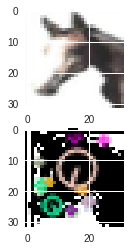

In [0]:
index_random = np.random.randint(x_train.shape[0])
sample_image = x_train[index_random]
sample_image = sample_image.astype("uint8")
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.imshow(x_train[index_random])
plt.subplot(2,1,2)
plt.imshow(img)
plt.show()

### Deep Network con mal desempeño (Sin pre-procesar v/s pre-procesadas)

Ahora elegimos un modelo profundo de los anteriores para entrenar data no procesada y pre-procesada, para ver la diferencia.


In [0]:
batch_size = 128
epochs = 25

from keras import regularizers

# Model Pre-process
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (7, 7), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Whitout Pre-processing data
test_loss = []
test_acc = []
opt = SGD(lr=0.01, momentum=0.9, decay=0.01)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history1 = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test))],verbose=2)
test_loss_m1 = np.array(test_loss)
test_acc_m1 = np.array(test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        200768    
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [0]:
# Pre-processing data
x_train_sift = calculate_sift(x_train)
x_test_sift = calculate_sift(x_test)
x_val_sift = calculate_sift(x_val)
# Normalizate
x_train_sift = x_train_sift.reshape(45000,16,8,1)
x_test_sift = x_test_sift.reshape(10000,16,8,1)
x_val_sift = x_val_sift.reshape(5000,16,8,1)

In [0]:
# Model
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train_sift.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (7, 7), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train_sift.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model.fit(x_train_sift, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_sift,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test_sift, y_test))],verbose=2)
test_loss_m2 = np.array(test_loss)
test_acc_m2 = np.array(test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 8, 64)         3200      
_________________________________________________________________
activation_7 (Activation)    (None, 16, 8, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 8, 64)         200768    
_________________________________________________________________
activation_8 (Activation)    (None, 16, 8, 64)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 4, 128)         73856     
__________

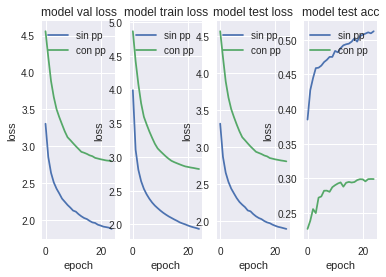

In [0]:
# Plot validation loss
plt.subplot(1,4,1)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.title('model val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['sin pp','con pp'], loc='upper right')

# Plot training loss
plt.subplot(1,4,2)
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['sin pp','con pp'], loc='upper right')

# Plot validation and test data
plt.subplot(1,4,3)
plt.plot(test_loss_m1)
plt.plot(test_loss_m2)
plt.title('model test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['sin pp','con pp'], loc='upper right')

# Plot training loss
plt.subplot(1,4,4)
plt.plot(test_acc_m1)
plt.plot(test_acc_m2)
plt.title('model test acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['sin pp','con pp'], loc='upper right')

#### Entrenamiento
Se puede ver que el desempeño al pre-procesar los datos es peor y puede ser debido a que la red debe aprender más cualidades o posibles cualidades de una clase, lo cual lo hace más complejo y puede que requiera una red más profunda o de mayor densidad. 

> **k)** Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

### Predicción de pares de objetos
Ahora nos interesa buscar las predicciones malas de nuestro modelo, es decir cuando predijo mal una clase y además por cual de las clases predijo mal, es decir: eligió auto cuando debió ser camión. 

In [0]:
# Model
test_loss = []
test_acc = []
model = Sequential()
model.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (7, 7), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# Training and testing model 1
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_59 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 128)       401536    
_________________________________________________________________
activation_60 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
__________

In [0]:
predic = model.predict(x_test)
pairs = np.where(predic != y_test)
row,col = pairs
pair = []
all_pairs = []
for i in range(len(row)):
  if len(pair)==0:
    pair.append(label_names[col[i]])
  elif len(pair)==1:
    pair.append(label_names[col[i]])
    all_pairs.append(pair)
    pair = []

all_pairs = np.array(all_pairs)

In [0]:
animals = ['bird','cat','deer','dog','frog','horse']
ve = ['airplane','automobile','truck','ship']
eq = 0; dif=0;
for p in all_pairs:
  if (p[0] in animals and p[1] in ve) or (p[0] in ve and p[1] in animals):
    dif = dif+1
  else:
    eq = eq+1
print(eq,dif)

50000 0


#### Entrenamieto
Observando que hay dos tipos de clases, de forma global podrían verse como animales y vehículos. En la parte del código se contó la cantidad de errores que habia entre una misma clasificación y entre ambas, concluyendo que todos los errores de predicción eran entre clases de la misma clasificación, es decir entre animal-animal o vehóculo-vehículo. Lo cual nos demuestra que igual afecta como al grupo de clases que pertenecen las imágenes.

### Visualización de pesos y efecto de filtros
Aquí se mostrarán primero como afectan las difernetes capas a una imagen y además como quedan los pesos de la primera y última cpa convolucional de la red, sin entrenar y entrenada.

In [0]:
def printer(model, im):
    '''prints the cat as a 2d array'''
    im_batch = np.expand_dims(im,axis=0)
    conv_im2 = model.predict(im_batch)

    conv_im2 = np.squeeze(conv_im2, axis=0)
    #print(conv_im2.shape)
    conv_im2 = conv_im2.reshape(conv_im2.shape[:2])

    #print(conv_im2.shape)
    plt.imshow(conv_im2)
    plt.show()

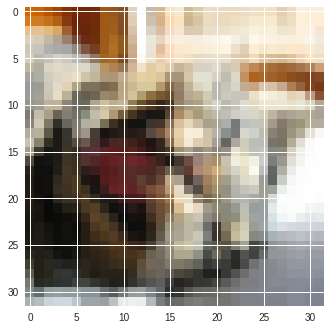

Primera convolucional


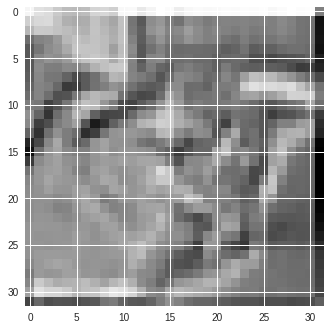

Primera relu


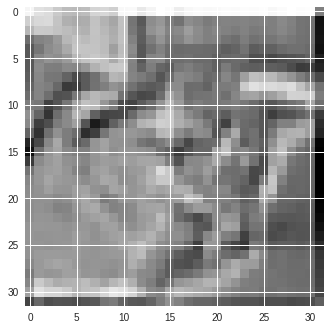

Segunda convolucional


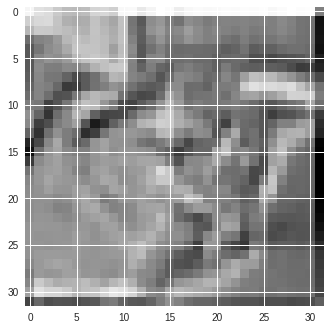

segunda relu


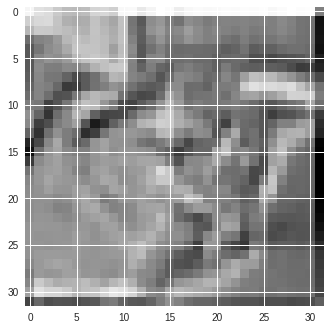

pooling, dropout y tercera convolucional


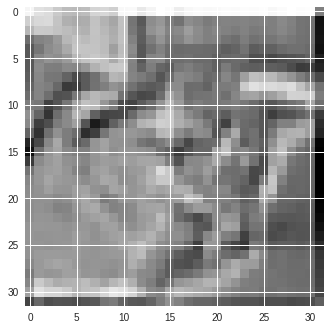

tercera relu


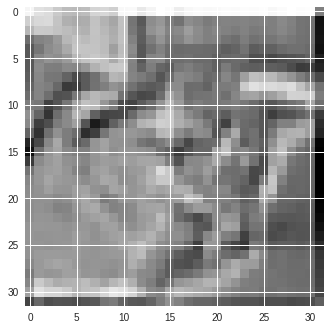

cuarta convolucion


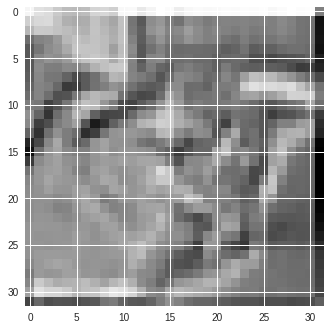

cuarta relu


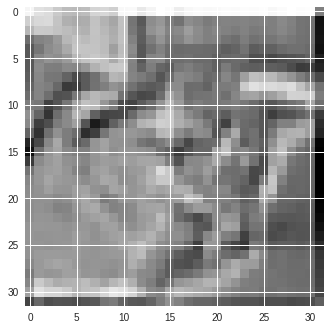

In [0]:
img = x_train[np.random.randint(x_train.shape[0])]
plt.imshow(img)
plt.show()

# Model
modelD = Sequential()
print('Primera convolucional')
modelD.add(Conv2D(1, (3, 3), padding='same', input_shape=img.shape,kernel_regularizer=regularizers.l2(0.01)))
printer(modelD,img)
print('Primera relu')
modelD.add(Activation('relu'))
printer(modelD,img)
print('Segunda convolucional')
modelD.add(Conv2D(1, (2, 2), padding='same',kernel_regularizer=regularizers.l2(0.01)))
printer(modelD,img)
print('segunda relu')
modelD.add(Activation('relu'))
printer(modelD,img)
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.2))
print('pooling, dropout y tercera convolucional')
modelD.add(Conv2D(1, (10, 10), padding='same', input_shape=img.shape,kernel_regularizer=regularizers.l2(0.01)))
printer(modelD,img)
print('tercera relu')
modelD.add(Activation('relu'))
printer(modelD,img)
print('cuarta convolucion')
modelD.add(Conv2D(1, (10, 10), padding='same',kernel_regularizer=regularizers.l2(0.01)))
printer(modelD,img)
print('cuarta relu')
modelD.add(Activation('relu'))
printer(modelD,img)
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.5))
modelD.add(Flatten())
modelD.add(Dense(512))
#printer(modelD,img)
modelD.add(Activation('relu'))
#printer(modelD,img)
modelD.add(Dense(10))
#printer(modelD,img)
modelD.add(Activation('softmax'))
#modelD.summary()

#### Entrenamiento
Se puede observar que la imagen se va distorsionando con el fin de obtener diferentes características, por ejemplo lo más notorio es la transformación del feature a la primera capa a la convolucion donde se peude ver la enfatización en los relieves de contornos de la imagen.

#### Definimos el modelo, para visualizar sin entrenar

In [0]:
# Model 2
modelD = Sequential()
modelD.add(Conv2D(64, (7, 7), padding='same', input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(Conv2D(64, (7, 7), padding='same',kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.2))
modelD.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Dropout(0.5))
modelD.add(Flatten())
modelD.add(Dense(512))
modelD.add(Activation('relu'))
modelD.add(Dense(10))
modelD.add(Activation('softmax'))
modelD.summary()

test_loss = []
test_acc = []
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
modelD.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# history = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
activation_67 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 64)        200768    
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 128)       73856     
__________

### Pesos sin entrenar

Capa 1 Conv no entrenada


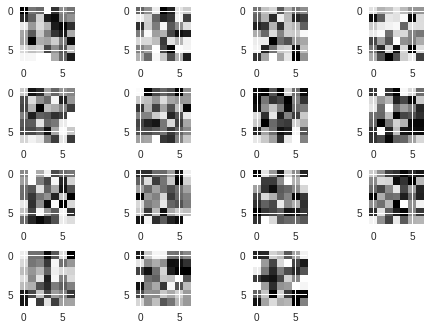

Ultima capa Conv no entrenada


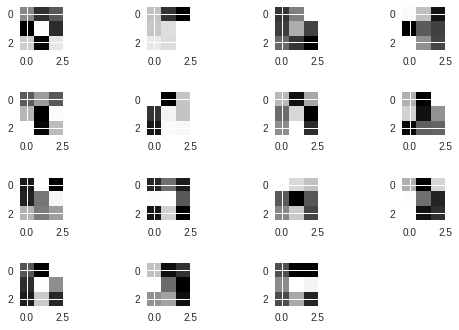

In [0]:
plt.subplots_adjust(wspace = 0.2,hspace = 0.5)
print('Capa 1 Conv no entrenada')
w_l0 = modelD.layers[0].get_weights()[0][:,:,0,:]

for i in range(1,16):
  plt.subplot(4,4,i)
  plt.imshow(w_l0[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

print('Ultima capa Conv no entrenada')
w_lf = modelD.layers[8].get_weights()[0][:,:,0,:]
plt.subplots_adjust(wspace = 1.0,hspace = 1)
for i in range(1,16):
  plt.subplot(4,4,i)
  plt.imshow(w_lf[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

#### Entrenamos el modelo

In [0]:
batch_size = 128
epochs = 20
history = modelD.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate,TestCallback((x_test, y_test))],verbose=2)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
 - 30s - loss: 4.8857 - acc: 0.1566 - val_loss: 4.4670 - val_acc: 0.2666

Testing loss: 4.480722567749023, acc: 0.2622

Epoch 2/20
 - 28s - loss: 4.2889 - acc: 0.2797 - val_loss: 4.0066 - val_acc: 0.3290

Testing loss: 4.016859199523926, acc: 0.3409

Epoch 3/20
 - 28s - loss: 3.8371 - acc: 0.3464 - val_loss: 3.5996 - val_acc: 0.3878

Testing loss: 3.610332260894775, acc: 0.395

Epoch 4/20
 - 28s - loss: 3.4732 - acc: 0.3837 - val_loss: 3.2635 - val_acc: 0.4110

Testing loss: 3.2692394039154054, acc: 0.4159

Epoch 5/20
 - 28s - loss: 3.2392 - acc: 0.4060 - val_loss: 3.1047 - val_acc: 0.4350

Testing loss: 3.1188772716522215, acc: 0.4374

Epoch 6/20
 - 28s - loss: 3.1087 - acc: 0.4160 - val_loss: 2.9792 - val_acc: 0.4568

Testing loss: 2.991234197998047, acc: 0.448

Epoch 7/20
 - 28s - loss: 2.9929 - acc: 0.4217 - val_loss: 2.8832 - val_acc: 0.4526

Testing loss: 2.896396452331543, acc: 0.4459

Epoch 8/20
 - 28s - loss: 2.8884 -

Capa 1 Conv entrenada


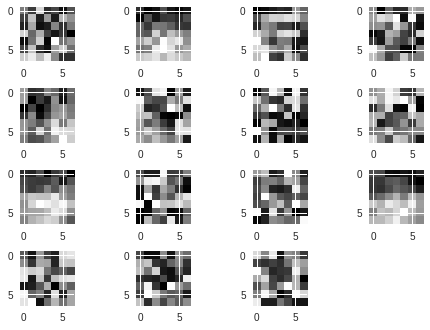

Ultima capa Conv entrenada


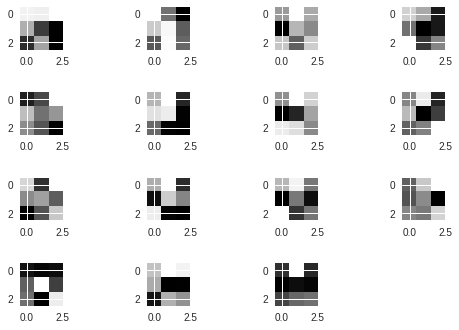

In [0]:
plt.subplots_adjust(wspace = 0.2,hspace = 0.5)
print('Capa 1 Conv entrenada')
w_l0 = modelD.layers[0].get_weights()[0][:,:,0,:]

for i in range(1,16):
  plt.subplot(4,4,i)
  plt.imshow(w_l0[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

print('Ultima capa Conv entrenada')
w_lf = modelD.layers[8].get_weights()[0][:,:,0,:]
plt.subplots_adjust(wspace = 1.0,hspace = 1)
for i in range(1,16):
  plt.subplot(4,4,i)
  plt.imshow(w_lf[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

#### Entrenamiento 
Se puede observar que después de entrenar hay más cantidad de pesos más importantes (más negros) que varian de acuerdo al mapeo (ya que cada map entrega diferentes características), además se puede ver que están más juntos y no colocados de forma tan aleatoria como antes de entrenar